# Exercise-2

> I will be using a different model `tf.keras.applications.efficientnet_v2` as the base model for training.

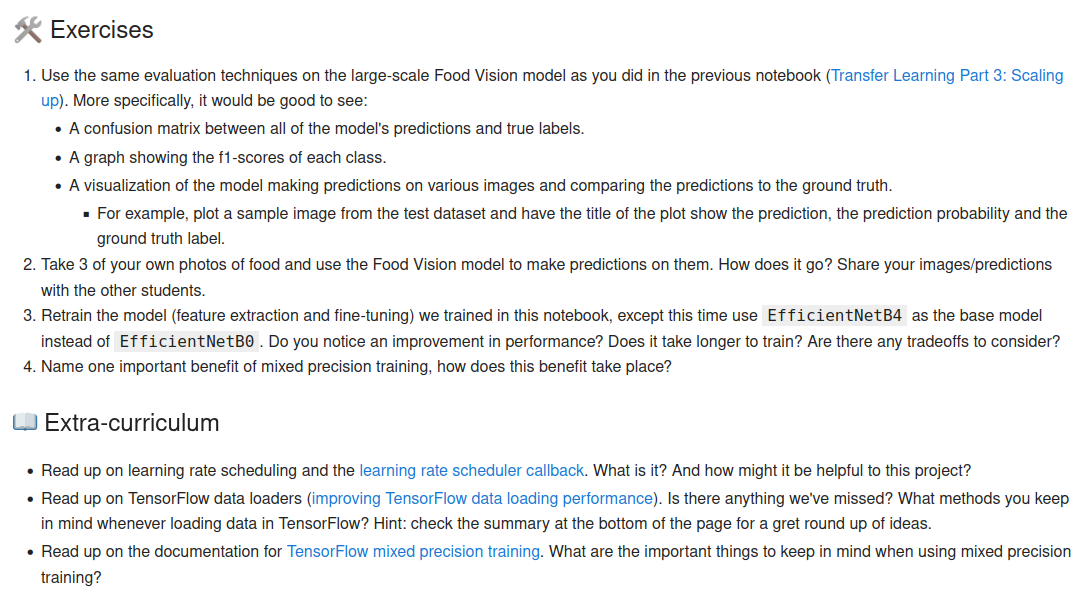

## An Error was happening when trying to train the feature extraction model

[Error Link](https://github.com/tensorflow/models/issues/10590)

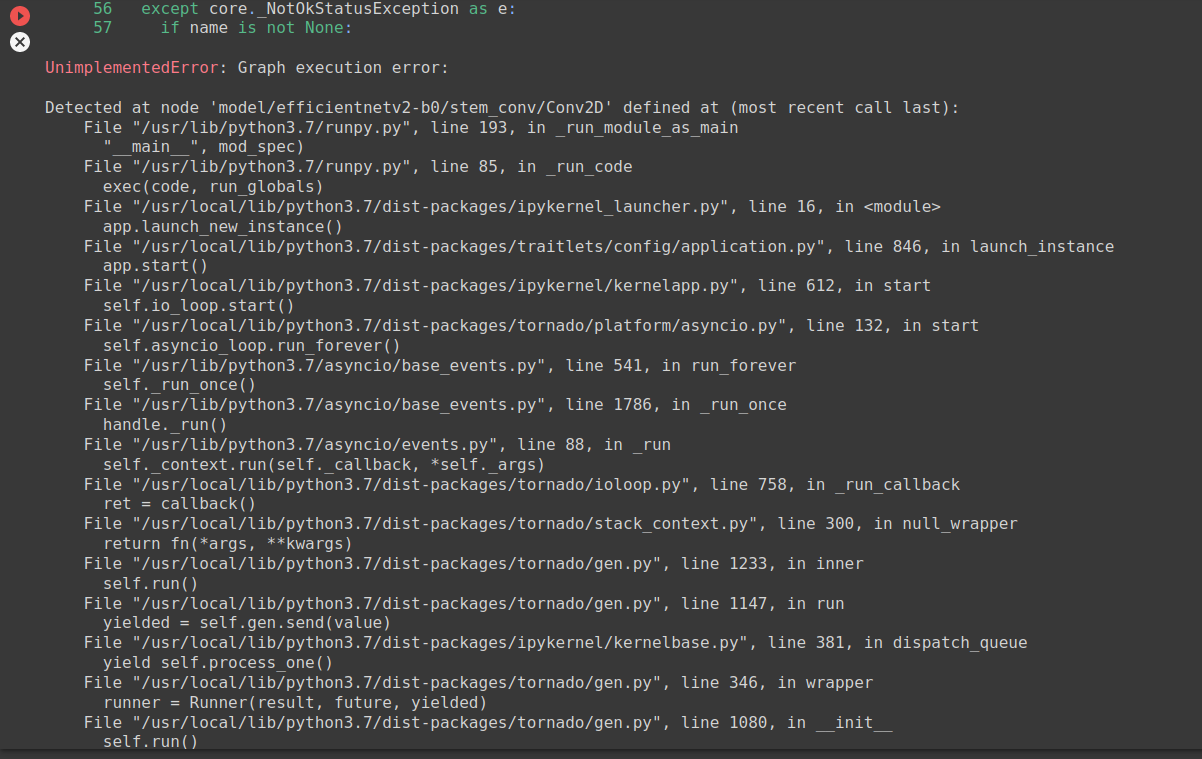

## Error Solution

In [1]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 7s (61.4 MB/s)
(Reading database ... 155676 files and directories currently installed.)
Removing libcudnn8-dev (8.0.5.39-1+cuda11.1) ...
(Reading database ... 155654 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.77-1+cuda11.2_amd64.deb ...
Unpacking libcudnn8 (8.1.0.77-1+c

## Imports

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import mixed_precision

import os
import random
import itertools

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

## Helper Function

In [3]:
!wget https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py

--2022-08-18 08:23:56--  https://raw.githubusercontent.com/arghanath007/MachineLearning/main/Deep%20Learning/Transfer%20Learning/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19296 (19K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  18.84K  --.-KB/s    in 0.001s  

2022-08-18 08:23:57 (25.7 MB/s) - ‘helper_functions.py’ saved [19296/19296]



In [4]:
from helper_functions import unzip_data, plot_loss_curves, compare_historys, create_data_augmented_layer_for_model, load_and_prep_image, make_confusion_matrix_for_larger_dataset

## Loading the dataset

In [5]:
(train_data, test_data), ds_info= tfds.load(name="food101", split=["train", "validation"], shuffle_files=False, as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteW29809/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteW29809/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_path='~/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo

In [7]:
class_names= ds_info.features['label'].names
len(class_names)

101

In [8]:
sample_1= train_data.take(5)
sample_1

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
for image, label in sample_1:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class or Label from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 56
  Class name (str form): huevos_rancheros
        

  Image shape: (384, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 76
  Class name (str form): pizza
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 21
  Class name (str form): chocolate_cake
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 64
  Class name (str form): miso_soup
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class or Label from Food101 (tensor form): 10
  Class name (str form): bruschetta
        


In [10]:
image.shape

TensorShape([512, 512, 3])

## Plotting image from the dataset

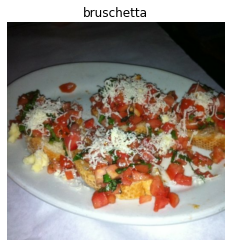

In [11]:
plt.imshow(image/255)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Preprocessing Image Function

In [12]:
from helper_functions import preprocess_image

In [13]:
processed_image, processed_label= preprocess_image(image, label)

In [14]:
processed_image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[ 12.943877  ,  12.943877  ,  12.943877  ],
        [ 12.357142  ,  12.357142  ,  12.357142  ],
        [ 11.280612  ,  11.280612  ,  11.280612  ],
        ...,
        [  1.        ,   5.        ,   4.        ],
        [  0.92855835,   4.9285583 ,   3.9285583 ],
        [  0.        ,   4.        ,   3.        ]],

       [[ 11.        ,  11.        ,  11.        ],
        [ 11.        ,  11.        ,  11.        ],
        [ 11.928572  ,  11.928572  ,  11.928572  ],
        ...,
        [  1.9285717 ,   5.9285717 ,   4.9285717 ],
        [  1.        ,   5.        ,   4.        ],
        [  0.9744874 ,   4.9744873 ,   3.9744873 ]],

       [[ 13.        ,  13.        ,  13.        ],
        [ 12.801021  ,  12.801021  ,  12.801021  ],
        [ 11.954082  ,  11.954082  ,  11.954082  ],
        ...,
        [  2.        ,   6.        ,   5.        ],
        [  1.9438673 ,   5.943867  ,   4.943867  ],
        [  1.13774

In [15]:
processed_image_1, processed_label_1= preprocess_image(image, label, scaling=True)

In [16]:
processed_image_1

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.0507603 , 0.0507603 , 0.0507603 ],
        [0.04845938, 0.04845938, 0.04845938],
        [0.0442377 , 0.0442377 , 0.0442377 ],
        ...,
        [0.00392157, 0.01960784, 0.01568628],
        [0.00364141, 0.01932768, 0.01540611],
        [0.        , 0.01568628, 0.01176471]],

       [[0.04313726, 0.04313726, 0.04313726],
        [0.04313726, 0.04313726, 0.04313726],
        [0.04677871, 0.04677871, 0.04677871],
        ...,
        [0.00756303, 0.0232493 , 0.01932773],
        [0.00392157, 0.01960784, 0.01568628],
        [0.00382152, 0.01950779, 0.01558622]],

       [[0.05098039, 0.05098039, 0.05098039],
        [0.05020008, 0.05020008, 0.05020008],
        [0.04687875, 0.04687875, 0.04687875],
        ...,
        [0.00784314, 0.02352941, 0.01960784],
        [0.00762301, 0.02330928, 0.01938771],
        [0.00446176, 0.02014803, 0.01622646]],

       ...,

       [[0.62184864, 0.63361335, 0.69243693],
        [0.61

original Image
Image shape: (512, 512, 3) Image dtype: <dtype: 'uint8'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


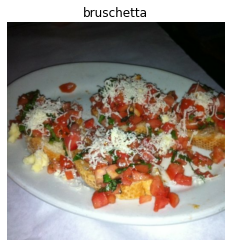

In [17]:
print("original Image")
plt.imshow(image)
plt.title(class_names[label.numpy()])
print(f"""Image shape: {image.shape} Image dtype: {image.dtype} Target class or Label from Food101 (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}""")
plt.axis(False);

original Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


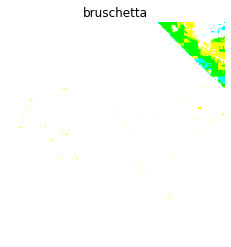

In [18]:
print("original Image")
plt.imshow(processed_image)
plt.title(class_names[processed_label.numpy()])
print(f"""Image shape: {processed_image.shape} Image dtype: {processed_image.dtype} Target class or Label from Food101 (tensor form): {processed_label}
    Class name (str form): {class_names[processed_label.numpy()]}""")
plt.axis(False);

original Image
Image shape: (224, 224, 3) Image dtype: <dtype: 'float32'> Target class or Label from Food101 (tensor form): 10
    Class name (str form): bruschetta


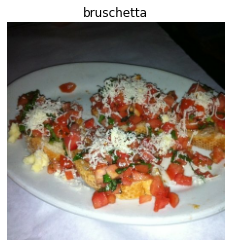

In [19]:
print("original Image")
plt.imshow(processed_image_1)
plt.title(class_names[processed_label_1.numpy()])
print(f"""Image shape: {processed_image_1.shape} Image dtype: {processed_image_1.dtype} Target class or Label from Food101 (tensor form): {processed_label_1}
    Class name (str form): {class_names[processed_label_1.numpy()]}""")
plt.axis(False);

## Creating the `train and test` dataset batches

In [20]:
train_data= train_data.map(map_func= preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_data= train_data.shuffle(buffer_size=1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE) # Shuffeling the training dataset
test_data= test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Feature Extraction Model Callbacks

In [22]:
from helper_functions import  create_tensorboard_callback, model_check_point_callback, create_early_stopping_callback, reduce_learning_rate_callback

In [23]:
# Model Checkpoint Callback
checkpoint_feature_extraction= 'checkpoints/feature_extraction_model'
checkpoint_callback=model_check_point_callback(checkpoint_feature_extraction, save_weights_only=True, save_best_only=True, monitor="val_loss")

# Tensorboard Callback
tensorboard_callback= create_tensorboard_callback("transfer_learning", "101_classes_feature_extraction_all_data")

# Early Stopping Callback
early_stopping_callback= create_early_stopping_callback(monitor="val_accuracy", patience=5)

# Learning Rate Scheduler

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Reduce Learing Rate Callback

learning_rate_reduce_callback= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_feature_extraction_all_data/20220818-083228


## Augmented Layer

In [24]:
augmented_layer=create_data_augmented_layer_for_model(RandomFlip="horizontal", RandomRotation=0.2, RandomZoom=0.2, RandomHeight=0.2, RandomWidth=0.2)
augmented_layer

## Turning on Mixed Precision Training

In [25]:
mixed_precision.set_global_policy("mixed_float16")

In [26]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Feature Extraction Model

In [27]:
# Create base model
input_shape = (224, 224, 3)
CLASS_COUNT= len(class_names)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = preprocessing.Rescaling(1./255)(x)
x= augmented_layer(inputs)
x = base_model(x, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x=  tf.keras.layers.Dropout(0.2, name="dropout_layer")(x) # Dropout Layer
x= layers.Dense(units= CLASS_COUNT,kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),bias_regularizer=regularizers.L2(1e-4), activity_regularizer=regularizers.L2(1e-5), name='regularization_layer')(x) # Regularization Layer
x = layers.Dense(CLASS_COUNT)(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

24274472/24274472 [==============================] - 0s 0us/step


In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, 224, 224, 3)      0         
 quential)                                                       
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                             

In [29]:
for layer in base_model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7fa2cff7bbd0> input_1 float32 <Policy "float32">
<keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fa2d3d37b10> rescaling float32 <Policy "mixed_float16">
<keras.layers.preprocessing.normalization.Normalization object at 0x7fa2cff7b610> normalization float32 <Policy "mixed_float16">
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa2cff617d0> stem_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa2d0970150> stem_bn float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7fa2cbf46990> stem_activation float32 <Policy "mixed_float16">
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa2cbf4e510> block1a_project_conv float32 <Policy "mixed_float16">
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa2cbf35350> block1a_project_bn float32 <Policy "mixed_float16">
<keras.layers.core

In [30]:
for layer in model.layers:
  print(layer, layer.name, layer.dtype, layer.dtype_policy)

<keras.engine.input_layer.InputLayer object at 0x7fa2d097c050> input_layer float32 <Policy "float32">
<keras.engine.sequential.Sequential object at 0x7fa2cff7b890> data_augmentation_layer float32 <Policy "float32">
<keras.engine.functional.Functional object at 0x7fa2cc1738d0> efficientnetv2-b0 float32 <Policy "mixed_float16">
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa2cf863d90> pooling_layer float32 <Policy "mixed_float16">
<keras.layers.regularization.dropout.Dropout object at 0x7fa2cf564790> dropout_layer float32 <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x7fa2ce579350> regularization_layer float32 <Policy "mixed_float16">
<keras.layers.core.dense.Dense object at 0x7fa2cfb25b10> dense float32 <Policy "mixed_float16">
<keras.layers.core.activation.Activation object at 0x7fa2ce599090> softmax_float32 float32 <Policy "float32">


In [31]:
history_101_food_classes_feature_extract = model.fit(train_data, epochs=3,steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=int(0.15 * len(test_data)),callbacks=[tensorboard_callback, checkpoint_callback, lr_scheduler_callback, learning_rate_reduce_callback])

Epoch 1/10
2368/2368 [==============================] - ETA: 0s - loss: 2.3842 - accuracy: 0.4342
Epoch 1: val_loss improved from inf to 1.46258, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 284s 112ms/step - loss: 2.3842 - accuracy: 0.4342 - val_loss: 1.4626 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 2/10
2368/2368 [==============================] - ETA: 0s - loss: 2.0238 - accuracy: 0.5181
Epoch 2: val_loss improved from 1.46258 to 1.40171, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 233s 98ms/step - loss: 2.0238 - accuracy: 0.5181 - val_loss: 1.4017 - val_accuracy: 0.6425 - lr: 0.0010
Epoch 3/10
2368/2368 [==============================] - ETA: 0s - loss: 1.9765 - accuracy: 0.5317
Epoch 3: val_loss improved from 1.40171 to 1.38040, saving model to checkpoints/feature_extraction_model
2368/2368 [==============================] - 225s 94ms/step - loss: 1.9765 - accuracy: 0.5317 - 

In [32]:
tf.__version__

'2.9.1'

In [33]:
model.evaluate(test_data)

790/790 [==============================] - 51s 65ms/step - loss: 1.3001 - accuracy: 0.6871


[1.300118327140808, 0.6871287226676941]

In [ ]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [ ]:
result_feature_extraction= model.evaluate(test_data)
result_feature_extraction

In [36]:
saved_model_dir='saved_models/model_feature_extraction_model'

In [ ]:
model.save(saved_model_dir)

## Load the saved Feature Extraction Model

In [ ]:
loaded_model= tf.keras.models.load_model(saved_model_dir)

In [39]:
loaded_model_result=loaded_model.evaluate(test_data)
loaded_model_result

790/790 [==============================] - 53s 65ms/step - loss: 1.3001 - accuracy: 0.6871


[1.300118327140808, 0.6871287226676941]

## Checking if the model saved/loaded correctly

In [ ]:
loaded_model_result == result_feature_extraction

In [ ]:
np.allclose(result_feature_extraction, loaded_model_result)

## Checking the layers of the loaded model

In [ ]:
for layer in loaded_model.layers:
  print(layer, layer.name, layer.trainable)

In [ ]:
for layer in loaded_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

## Unfreezing all the layers of the base_model i.e EfficientNetB4 for Fine-Tuning

In [44]:
for layer in loaded_model.layers:
  layer.trainable= True
  print(layer, layer.name, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa2ce620e50> input_layer True
<keras.engine.sequential.Sequential object at 0x7fa233458dd0> data_augmentation_layer True
<keras.engine.functional.Functional object at 0x7fa2ce96f810> efficientnetv2-b0 True
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fa2336ccad0> pooling_layer True
<keras.layers.regularization.dropout.Dropout object at 0x7fa2cd818490> dropout_layer True
<keras.layers.core.dense.Dense object at 0x7fa2ccf5f490> regularization_layer True
<keras.layers.core.dense.Dense object at 0x7fa2ccfc4790> dense True
<keras.layers.core.activation.Activation object at 0x7fa2cd7f6c90> softmax_float32 True


In [45]:
for layer in loaded_model.layers[1].layers:
  print(layer, layer.name, layer.trainable)

<keras.layers.preprocessing.image_preprocessing.RandomFlip object at 0x7fa2ce966050> random_flip True
<keras.layers.preprocessing.image_preprocessing.RandomRotation object at 0x7fa2cd7f6e50> random_rotation True
<keras.layers.preprocessing.image_preprocessing.RandomZoom object at 0x7fa233714250> random_zoom True
<keras.layers.preprocessing.image_preprocessing.RandomHeight object at 0x7fa233714490> random_height True
<keras.layers.preprocessing.image_preprocessing.RandomWidth object at 0x7fa2cebba890> random_width True


In [46]:
for layer in loaded_model.layers[1].layers:
  if layer.trainable == False:
    print(layer, layer.name, layer.trainable)

In [47]:
for layer in base_model.layers:
  if layer.trainable == True:
    print(layer, layer.name)

In [48]:
len(loaded_model.layers)

8

In [49]:
len(loaded_model.trainable_variables)

245

In [50]:
len(base_model.trainable_variables)

0

In [51]:
len(base_model.layers)

270

## Callback for Fine-Tuning All unfrozen layers

In [52]:
checpoint_fine_tuning= "checkpoints_fine_tuning_all"

checkpoint_callback_fine_tuning_all_unfrozen=model_check_point_callback(checpoint_fine_tuning, save_weights_only=True, save_best_only=True, monitor="val_accuracy")
tensorboard_callback_fine_tuning_all_unfrozen= create_tensorboard_callback("transfer_learning", "101_classes_fine_tuning_all_data_all_unfrozen_layers")
early_stopping_callback_fine_tuning_all_unfrozen= create_early_stopping_callback(monitor="val_loss", patience=5)
learning_rate_reduce_callback_all_unfrozen= reduce_learning_rate_callback(monitor="val_loss", factor=0.2, patience=2, minimum_lr=1e-7)

Saving TensorBoard log files to: transfer_learning/101_classes_fine_tuning_all_data_all_unfrozen_layers/20220818-091847


In [53]:
loaded_model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [54]:
history_fine_tuned_all= loaded_model.fit(train_data, epochs=100, steps_per_epoch=len(train_data) ,validation_data= test_data, validation_steps=int(0.15 * len(test_data)), callbacks=[checkpoint_callback_fine_tuning_all_unfrozen, tensorboard_callback_fine_tuning_all_unfrozen, early_stopping_callback_fine_tuning_all_unfrozen, learning_rate_reduce_callback_all_unfrozen])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.4296 - accuracy: 0.6645
Epoch 1: val_accuracy improved from -inf to 0.72617, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 860s 355ms/step - loss: 1.4296 - accuracy: 0.6645 - val_loss: 1.1502 - val_accuracy: 0.7262 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 1.1493 - accuracy: 0.7314
Epoch 2: val_accuracy improved from 0.72617 to 0.76668, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 459s 193ms/step - loss: 1.1493 - accuracy: 0.7314 - val_loss: 0.9962 - val_accuracy: 0.7667 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.9918 - accuracy: 0.7683
Epoch 3: val_accuracy improved from 0.76668 to 0.78284, saving model to checkpoints_fine_tuning_all
2368/2368 [==============================] - 403s 169ms/step - loss: 0.9918 - accuracy: 0.7683 - v

In [ ]:
loaded_model.summary()

In [ ]:
result_loaded_model_2=loaded_model.evaluate(test_data)
result_loaded_model_2

In [ ]:
plot_loss_curves(history_fine_tuned_all)

## Evaluating `loaded_model`

In [ ]:
pred_probs=loaded_model.predict(test_data, verbose=1)

In [ ]:
pred_classes= pred_probs.argmax(axis=1)

pred_classes[:5]

In [ ]:
y_labels = []
test_images = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

## Accuracy Score

In [ ]:
sklearn_accuracy= accuracy_score(y_true= y_labels, y_pred= pred_classes)
sklearn_accuracy

## Confusion Matrix

In [ ]:
cm = confusion_matrix(y_labels, pred_classes)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]==0
fig, ax = plt.subplots(figsize=(50,50))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Classification Report 

In [ ]:
print(classification_report(y_true= y_labels, y_pred= pred_classes))

In [ ]:
classification_report_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

## Visualizing the F1-score

In [ ]:
class_f1_scores= {}

# Looping through the classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break

  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]


class_f1_scores

In [ ]:
f1_scores= pd.DataFrame({"class_names": list(class_f1_scores.keys()), "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

## Tensorboard

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning \
--name "Transfer Learning on the Food101 dataset with EfficientNetB4" \
--description "Training a Transfer Learning model with EfficientNetB4 to beat the DeepFood paper which is based on the Food101 dataset." \
--one_shot

### Tensorboard Link 

Link -> https://tensorboard.dev/experiment/btYndH3jQrmKFWuvJnQ3RA/

In [ ]:
!tensorboard dev list

## Evaluating on custom dataset

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [ ]:
unzip_data('custom_food_images.zip')

In [ ]:
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

In [ ]:
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False) # load in target image and turn it into tensor
  pred_prob = loaded_model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class label
  # Plot the image with appropriate annotations
  plt.figure()
  plt.imshow(img/255.) # imshow() requires float inputs to be normalized
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)